[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [2]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [3]:
!nvidia-smi

Fri Mar  7 18:06:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [5]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 105.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [6]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-03-07 18:09:48--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-03-07 18:09:48 (168 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


100%|██████████| 51.2M/51.2M [00:01<00:00, 40.0MB/s]


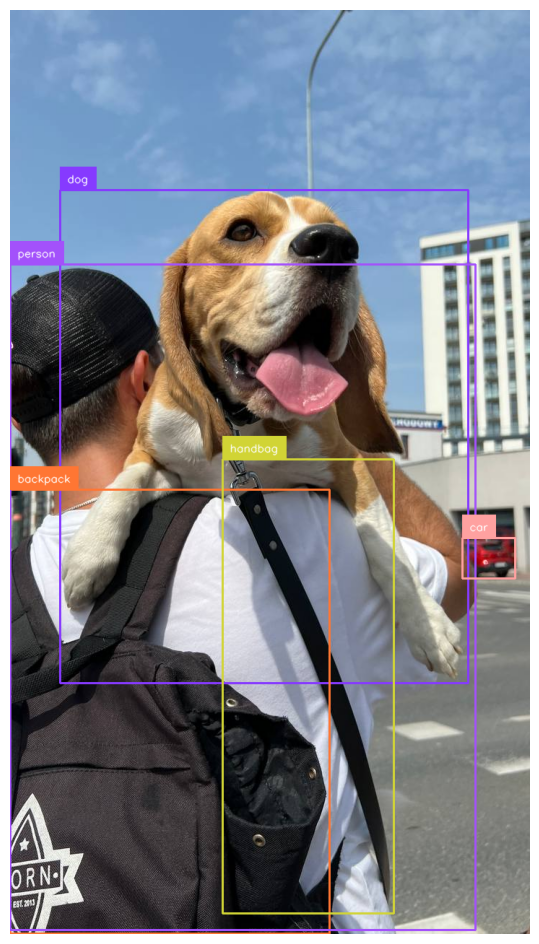

In [7]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [9]:
from roboflow import download_dataset
from roboflow import Roboflow

#dataset = download_dataset('https://universe.roboflow.com/roboflow-100/circuit-voltages/dataset/2', 'yolov8')


!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

workspace = rf.workspace("liangdianzhong")
project = rf.workspace("ships-kev8a").project("military-ship-detection")
version = project.version(48)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Military-Ship-Detection-48 in yolov11:: 100%|██████████| 5070/5070 [00:00<00:00, 5645.61it/s]


In [10]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [11]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [12]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 47
names: ['Aircraft-Carrier-Fujian-Class-CHI', 'Aircraft-Carrier-Kiev Class-IND', 'Aircraft-Carrier-Kuznetsov-Class-CHI', 'Aircraft-Carrier-Vikrant-Class-IND', 'Corvette-Azmat-Class-PAK', 'Corvette-Babur-Class-PAK', 'Corvette-Jiangdao-class-056-CHI', 'Corvette-Kamorta-Class-IND', 'Corvette-Khukri-Class-IND', 'Corvette-Kora-Class-IND', 'Corvette-Veer-Class-IND', 'Corvette-Yarmook-Class-PAK', 'Destroyer-Delhi-Class-IND', 'Destroyer-Kolkata-Class-IND', 'Destroyer-Luyang-III-class-052-CHI', 'Destroyer-Rajput-Class-IND', 'Destroyer-Renhai-Class-055-CHI', 'Destroyer-Visakhapatnam-Class-IND', 'Frigate-Brahmaputra-Class-IND', 'Frigate-Godavari-Class-IND', 'Frigate-Shivalik-Class-IND', 'Frigate-Talwar-Class-IND', 'Frigate-Tughril-Class-PAK', 'Frigate-Zulfiquar-Class-PAK', 'Landing-Ship-Austin-Class-IND', 'Landing-Ship-Magar-Class-IND', 'Landing-Ship-Shardul-Class-IND', 'Landing-Ship-Yushen-Class-075-CHI', 'Minesweeper-Pondic

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [13]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

New https://pypi.org/project/ultralytics/8.3.85 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/datasets/Military-Ship-Detection-48/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embe

100%|██████████| 755k/755k [00:00<00:00, 91.8MB/s]


Overriding model.yaml nc=80 with nc=47

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytic

100%|██████████| 5.34M/5.34M [00:00<00:00, 341MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/Military-Ship-Detection-48/train/labels... 1842 images, 26 backgrounds, 0 corrupt: 100%|██████████| 1842/1842 [00:00<00:00, 1990.60it/s]


train: New cache created: /content/datasets/Military-Ship-Detection-48/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/datasets/Military-Ship-Detection-48/valid/labels... 436 images, 9 backgrounds, 0 corrupt: 100%|██████████| 436/436 [00:00<00:00, 1036.24it/s]


val: New cache created: /content/datasets/Military-Ship-Detection-48/valid/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000196, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/116 [00:00<?, ?it/s]Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at ../aten/src/ATen/native/transformers/cuda/attention_backward.cu:655.)
      1/100      5.11G      3.182      5.463      4.217          5        640: 100%|██████████| 116/116 [00:47<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

                   all        436        460          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.99G      3.189      5.431      4.152          4        640: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.32it/s]


                   all        436        460    0.00101     0.0166    0.00071   0.000168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.02G      3.053      5.421      3.994          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

                   all        436        460   0.000582     0.0303     0.0004   8.85e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.01G      2.717      5.348      3.622          7        640: 100%|██████████| 116/116 [00:42<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.89it/s]

                   all        436        460   0.000733     0.0448    0.00068   0.000282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.01G      2.378      5.134       3.19          7        640: 100%|██████████| 116/116 [00:46<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


                   all        436        460    0.00145      0.284    0.00281    0.00072

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.02G      2.204      4.943      2.929          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.97it/s]

                   all        436        460    0.00276      0.376    0.00718    0.00182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.02G      2.079      4.771      2.764          6        640: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]

                   all        436        460    0.00188      0.527     0.0113    0.00379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.02G      1.978       4.63      2.635          6        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

                   all        436        460    0.00263      0.633    0.00851    0.00333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.02G      1.893      4.455       2.52          8        640: 100%|██████████| 116/116 [00:42<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.50it/s]

                   all        436        460    0.00307      0.778     0.0155    0.00685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.02G       1.79      4.242       2.41          8        640: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.55it/s]

                   all        436        460    0.00356      0.836     0.0207     0.0115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.02G      1.702      4.116      2.331          8        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]


                   all        436        460     0.0035      0.871     0.0278     0.0154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.02G      1.666      3.998      2.253          9        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]

                   all        436        460    0.00392      0.892     0.0308     0.0194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.02G      1.625      3.897      2.203          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]

                   all        436        460     0.0136      0.663     0.0303     0.0204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.04G      1.556      3.825       2.12          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]

                   all        436        460      0.191      0.199     0.0324     0.0218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.01G      1.512      3.748      2.091          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

                   all        436        460    0.00587      0.881     0.0344     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.02G      1.487      3.644      2.057          3        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

                   all        436        460    0.00555      0.946     0.0388     0.0271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      5.01G      1.442      3.601      2.013          7        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]

                   all        436        460    0.00629      0.902     0.0393      0.027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.02G      1.405       3.54      1.962          1        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        436        460    0.00969      0.921     0.0468      0.034



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.01G      1.387      3.526      1.951          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

                   all        436        460     0.0485      0.484     0.0499     0.0383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.02G      1.375       3.47       1.94          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

                   all        436        460    0.00666      0.923     0.0397     0.0281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.01G       1.35      3.431      1.907          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

                   all        436        460      0.245       0.26     0.0588     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.02G      1.323      3.396      1.886          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]

                   all        436        460     0.0101      0.947     0.0622     0.0486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.01G      1.297      3.386      1.859          2        640: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

                   all        436        460     0.0248      0.672     0.0553     0.0422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.02G      1.318      3.363      1.863          7        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]

                   all        436        460     0.0745      0.461     0.0576     0.0437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.01G      1.273      3.329      1.838          6        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

                   all        436        460      0.246      0.223     0.0589      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.01G      1.253      3.285      1.816          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

                   all        436        460     0.0241      0.708     0.0627     0.0461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.01G      1.252      3.264      1.808          4        640: 100%|██████████| 116/116 [00:45<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]

                   all        436        460     0.0283      0.658     0.0569     0.0435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.01G      1.227      3.248      1.787          3        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

                   all        436        460      0.451      0.119      0.067     0.0504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.01G      1.218      3.215      1.766          6        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.57it/s]

                   all        436        460      0.194      0.105     0.0554     0.0412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.01G      1.211      3.202      1.761          5        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]

                   all        436        460      0.208      0.253     0.0762     0.0596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.01G      1.218      3.181      1.767          3        640: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

                   all        436        460      0.185       0.26     0.0648       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.02G      1.194      3.155      1.736          8        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]

                   all        436        460      0.491      0.125     0.0641     0.0506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.03G      1.166      3.135      1.738          2        640: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

                   all        436        460      0.251      0.253     0.0816     0.0629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.01G      1.159      3.114      1.705          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

                   all        436        460      0.423      0.156     0.0851      0.069



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.01G      1.155      3.089      1.702          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.51it/s]

                   all        436        460      0.565      0.127     0.0836     0.0647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.02G      1.139      3.086      1.684          8        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

                   all        436        460      0.335      0.207     0.0762      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.01G      1.123       3.08      1.692          6        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

                   all        436        460      0.425      0.198     0.0768     0.0601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.02G      1.111      3.051       1.67          7        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

                   all        436        460       0.32      0.242     0.0799     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.01G      1.115      3.033      1.654          6        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

                   all        436        460      0.182      0.303       0.08     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.01G      1.082      3.015       1.65          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

                   all        436        460      0.134      0.438     0.0799     0.0615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.03G      1.102      3.038      1.665          3        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

                   all        436        460      0.216      0.319      0.088     0.0712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.03G      1.098      2.998      1.653          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]

                   all        436        460      0.321      0.184     0.0976     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.05G      1.067      2.974      1.618          8        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

                   all        436        460      0.417      0.203     0.0869     0.0683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.01G      1.071      2.971      1.627          5        640: 100%|██████████| 116/116 [00:44<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

                   all        436        460      0.459      0.161     0.0871     0.0693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.01G      1.042      2.961      1.612          5        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

                   all        436        460      0.433      0.188     0.0831     0.0662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      5.01G      1.051      2.937      1.608          5        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]

                   all        436        460      0.292      0.301     0.0915     0.0706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.01G      1.041       2.93      1.608          4        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

                   all        436        460        0.3      0.235      0.087     0.0661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.01G      1.004      2.911      1.575          8        640: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

                   all        436        460      0.306      0.209     0.0932     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.01G      1.044      2.908      1.605          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]

                   all        436        460      0.295      0.228     0.0983     0.0797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.01G      1.027      2.894      1.584          5        640: 100%|██████████| 116/116 [00:42<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

                   all        436        460       0.33      0.236      0.115     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.01G      1.002      2.899      1.573          2        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

                   all        436        460      0.412      0.229     0.0995     0.0791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.01G      1.022      2.895      1.583          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

                   all        436        460      0.393      0.206      0.108     0.0827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.01G      1.006      2.869      1.563          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]

                   all        436        460      0.309      0.265      0.102      0.082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.01G     0.9901      2.863      1.553          2        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]

                   all        436        460      0.303       0.27      0.107      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.01G      0.997      2.843       1.55          7        640: 100%|██████████| 116/116 [00:43<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

                   all        436        460      0.324      0.254      0.108      0.087



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.03G     0.9786       2.82      1.529          3        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]

                   all        436        460      0.337      0.267      0.118     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      5.01G     0.9652      2.827      1.524          4        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

                   all        436        460      0.281        0.3      0.119     0.0984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      5.01G     0.9871       2.83      1.546          5        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

                   all        436        460      0.301      0.275      0.118     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.01G     0.9686      2.813       1.53          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

                   all        436        460      0.307      0.289      0.128      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.01G     0.9732      2.811      1.544          5        640: 100%|██████████| 116/116 [00:44<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

                   all        436        460      0.285      0.274      0.129      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.01G     0.9566      2.795      1.525          6        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

                   all        436        460      0.241      0.294      0.117     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.01G     0.9624      2.793      1.529          8        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

                   all        436        460      0.271      0.301      0.108     0.0883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.01G     0.9447      2.789      1.515          3        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]

                   all        436        460      0.268      0.263      0.116     0.0952



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.01G     0.9421      2.762       1.52          6        640: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

                   all        436        460      0.301      0.289      0.123      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.01G     0.9368       2.75      1.498          7        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]

                   all        436        460      0.344      0.305       0.12     0.0978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.01G     0.9288      2.757      1.498          3        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]

                   all        436        460      0.316      0.298       0.13      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.01G     0.9408      2.764       1.51          6        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

                   all        436        460      0.266        0.3      0.127      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.01G     0.9239      2.735      1.494          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.74it/s]

                   all        436        460      0.245      0.316      0.133      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.01G     0.9258      2.728      1.492          6        640: 100%|██████████| 116/116 [00:42<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

                   all        436        460       0.26      0.303       0.13      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.01G     0.9272      2.733      1.493          3        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

                   all        436        460      0.301      0.297      0.135      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.01G     0.9336      2.722      1.496          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]

                   all        436        460      0.316      0.309      0.139      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.01G     0.9129       2.71      1.496          2        640: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]

                   all        436        460      0.332      0.303      0.139      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.01G     0.9116      2.706      1.482          4        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.54it/s]

                   all        436        460      0.285      0.317      0.153      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      5.01G     0.9113      2.703      1.486          5        640: 100%|██████████| 116/116 [00:42<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

                   all        436        460       0.27        0.3      0.145      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.01G     0.9053      2.695      1.481          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.07it/s]

                   all        436        460      0.235      0.345      0.141      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.01G     0.9009      2.692       1.47          3        640: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.93it/s]

                   all        436        460       0.23      0.345      0.169       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.01G     0.8896      2.665      1.463          5        640: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]

                   all        436        460      0.272      0.329      0.153      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.01G     0.8928      2.673      1.461          6        640: 100%|██████████| 116/116 [00:42<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.55it/s]

                   all        436        460      0.252      0.352      0.155       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.01G     0.8874       2.67      1.468          2        640: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]

                   all        436        460      0.308      0.366      0.156      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.01G     0.8877      2.653      1.471          4        640: 100%|██████████| 116/116 [00:44<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]

                   all        436        460      0.293      0.337      0.167      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.01G     0.8818      2.655      1.457          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

                   all        436        460       0.21      0.369      0.166      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.01G     0.8798      2.636      1.461          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.03it/s]

                   all        436        460      0.255       0.37      0.167       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.01G     0.8735      2.627      1.445          8        640: 100%|██████████| 116/116 [00:43<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]

                   all        436        460      0.241      0.357      0.167       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.01G     0.8867      2.632      1.462          6        640: 100%|██████████| 116/116 [00:44<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]

                   all        436        460      0.277      0.365      0.168      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.01G     0.8704      2.643      1.444          2        640: 100%|██████████| 116/116 [00:43<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

                   all        436        460      0.264      0.361      0.186      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.01G      0.874      2.635      1.454          6        640: 100%|██████████| 116/116 [00:43<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.00it/s]

                   all        436        460       0.32       0.36      0.187      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      5.01G     0.8744      2.624      1.449          6        640: 100%|██████████| 116/116 [00:43<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]

                   all        436        460      0.288       0.39      0.185      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.01G     0.8692      2.637      1.445          3        640: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]

                   all        436        460      0.265      0.384      0.177      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.01G     0.8574      2.618      1.444          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.85it/s]

                   all        436        460       0.29      0.349      0.188       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.01G     0.8562       2.62      1.434          4        640: 100%|██████████| 116/116 [00:43<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]

                   all        436        460      0.249      0.376      0.185      0.157


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.01G     0.6276      2.373      1.292          2        640: 100%|██████████| 116/116 [00:44<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]

                   all        436        460      0.209      0.392      0.174      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.01G     0.6047      2.279      1.271          2        640: 100%|██████████| 116/116 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

                   all        436        460      0.245      0.433      0.184      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.01G     0.5977      2.245      1.265          2        640: 100%|██████████| 116/116 [00:42<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.08it/s]

                   all        436        460      0.302      0.401      0.202      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.01G     0.5912      2.231      1.261          2        640: 100%|██████████| 116/116 [00:42<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]

                   all        436        460      0.291      0.397      0.207      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      5.01G     0.5948      2.207      1.261          2        640: 100%|██████████| 116/116 [00:41<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]

                   all        436        460      0.301      0.402      0.203      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.01G     0.5873       2.23      1.267          2        640: 100%|██████████| 116/116 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

                   all        436        460      0.302      0.394      0.215      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.01G     0.6009      2.213      1.265          2        640: 100%|██████████| 116/116 [00:42<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]

                   all        436        460      0.304      0.399      0.222       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.01G     0.5797       2.21      1.246          2        640: 100%|██████████| 116/116 [00:41<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

                   all        436        460      0.271      0.409      0.217      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.01G     0.5631      2.186      1.221          2        640: 100%|██████████| 116/116 [00:42<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.92it/s]

                   all        436        460      0.296      0.398      0.219       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.01G     0.5726      2.184      1.251          2        640: 100%|██████████| 116/116 [00:41<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:04<00:00,  2.98it/s]

                   all        436        460      0.289      0.394      0.216      0.187



100 epochs completed in 1.380 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 352 layers, 9,249,069 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]


                   all        436        460      0.304      0.399      0.222       0.19
Aircraft-Carrier-Fujian-Class-CHI          7          7     0.0685      0.429      0.299      0.211
Aircraft-Carrier-Kiev Class-IND         12         12      0.189          1      0.432      0.394
Aircraft-Carrier-Kuznetsov-Class-CHI          9          9      0.143      0.889      0.183      0.134
Aircraft-Carrier-Vikrant-Class-IND         15         15      0.175      0.867      0.341      0.301
Corvette-Azmat-Class-PAK          2          2          0          0    0.00193    0.00174
Corvette-Babur-Class-PAK         10         10          1          0     0.0962     0.0919
Corvette-Jiangdao-class-056-CHI          9         15          1          0     0.0532     0.0368
Corvette-Kamorta-Class-IND         17         18      0.125      0.556      0.143      0.131
Corvette-Khukri-Class-IND          5          5     0.0822        0.2      0.126      0.124
Corvette-Kora-Class-IND         11         1

## Evaluate fine-tuned YOLOv12 model

In [18]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/content/datasets/runs/detect/train



ls: cannot access '/content/content/datasets/runs/detect/train': No such file or directory


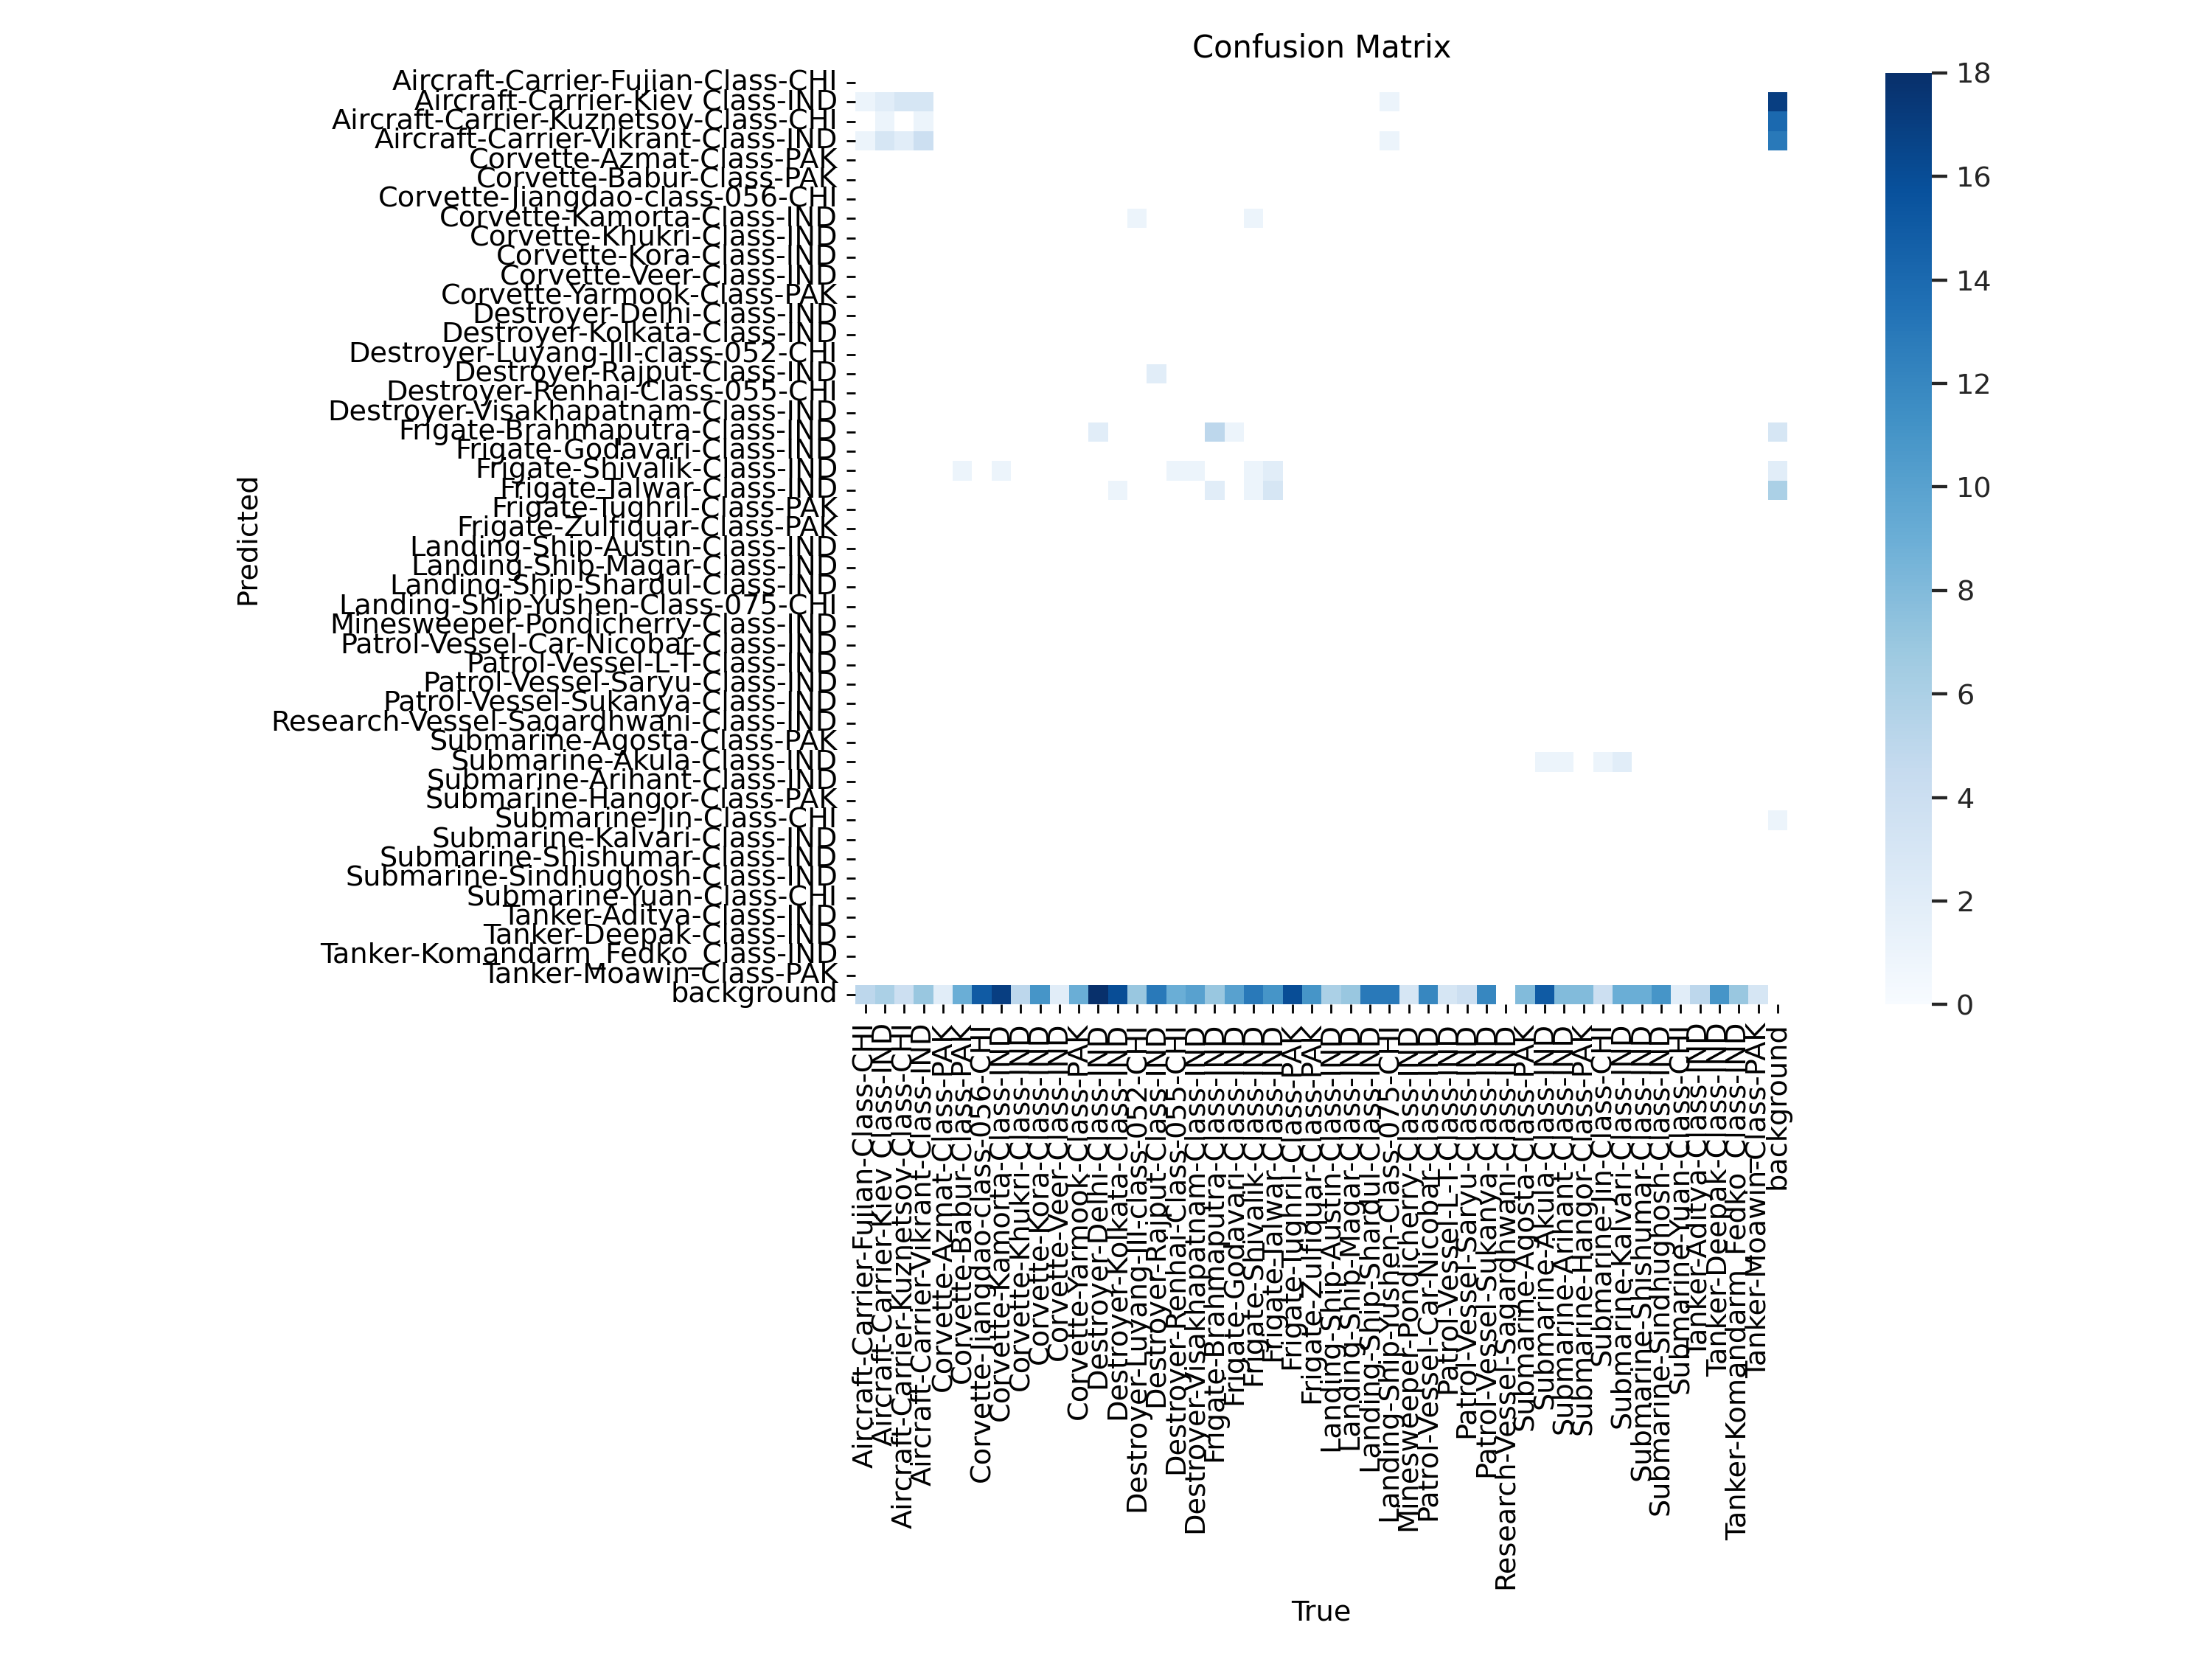

In [20]:
from IPython.display import Image

Image(filename=f'{HOME}/datasets/runs/detect/train/confusion_matrix.png', width=1000)

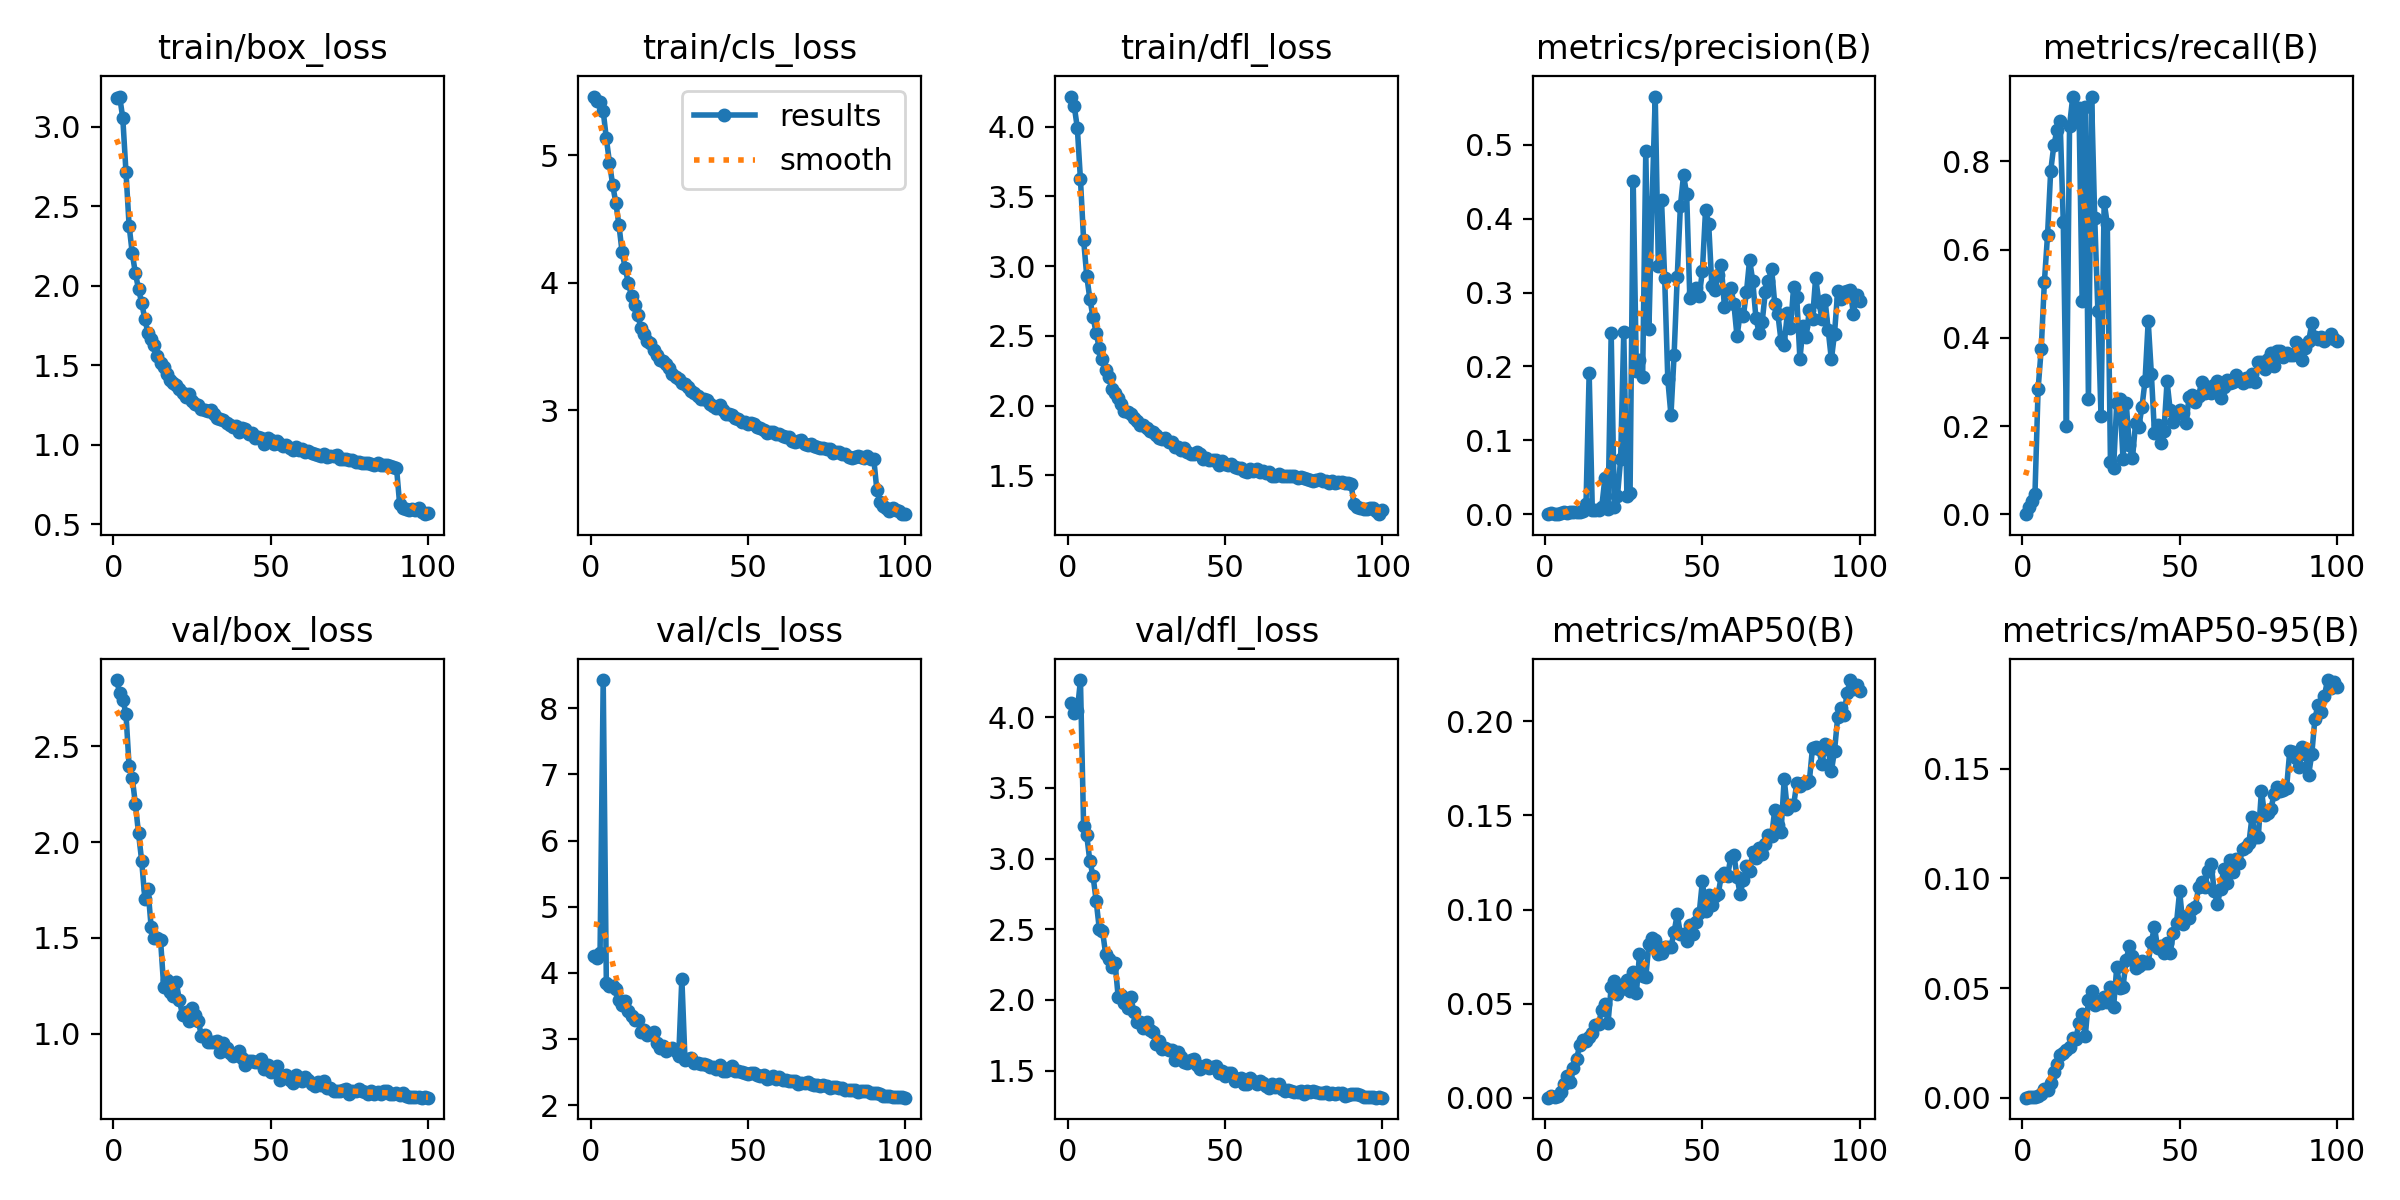

In [23]:
from IPython.display import Image

Image(filename=f'{HOME}/datasets/runs/detect/train/results.png', width=1000)

In [24]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Aircraft-Carrier-Fujian-Class-CHI',
 'Aircraft-Carrier-Kiev Class-IND',
 'Aircraft-Carrier-Kuznetsov-Class-CHI',
 'Aircraft-Carrier-Vikrant-Class-IND',
 'Corvette-Azmat-Class-PAK',
 'Corvette-Babur-Class-PAK',
 'Corvette-Jiangdao-class-056-CHI',
 'Corvette-Kamorta-Class-IND',
 'Corvette-Khukri-Class-IND',
 'Corvette-Kora-Class-IND',
 'Corvette-Veer-Class-IND',
 'Corvette-Yarmook-Class-PAK',
 'Destroyer-Delhi-Class-IND',
 'Destroyer-Kolkata-Class-IND',
 'Destroyer-Luyang-III-class-052-CHI',
 'Destroyer-Rajput-Class-IND',
 'Destroyer-Renhai-Class-055-CHI',
 'Destroyer-Visakhapatnam-Class-IND',
 'Frigate-Brahmaputra-Class-IND',
 'Frigate-Godavari-Class-IND',
 'Frigate-Shivalik-Class-IND',
 'Frigate-Talwar-Class-IND',
 'Frigate-Tughril-Class-PAK',
 'Frigate-Zulfiquar-Class-PAK',
 'Landing-Ship-Austin-Class-IND',
 'Landing-Ship-Magar-Class-IND',
 'Landing-Ship-Shardul-Class-IND',
 'Landing-Ship-Yushen-Class-075-CHI',
 'Minesweeper-Pondicherry-Class-IND',
 'Patrol-Vessel-Car-Nicobar-Class-

In [27]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/datasets/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.4163714694317025
mAP 50 0.8842411767309134
mAP 75 0.33123104776171636


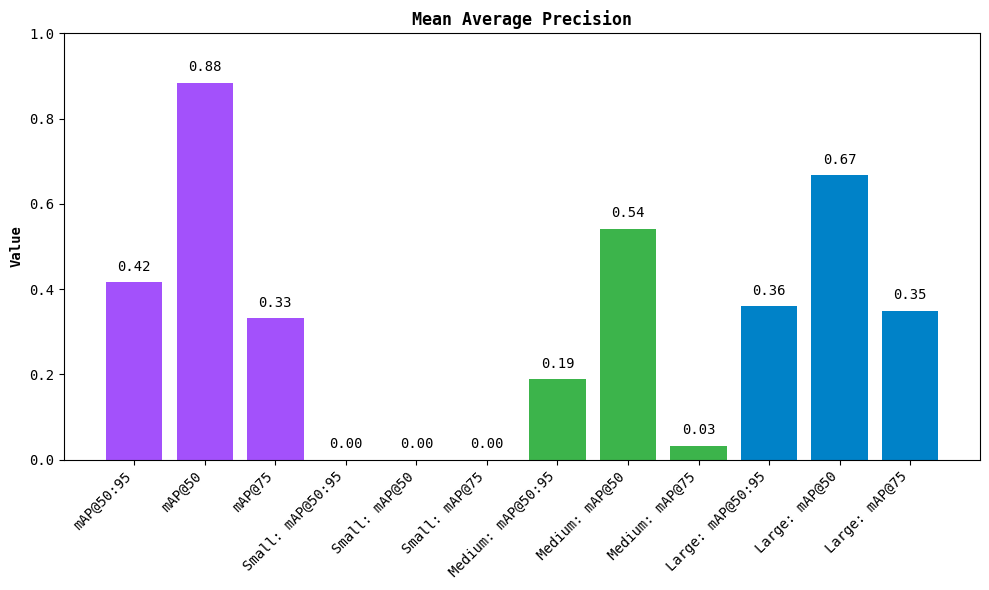

In [ ]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [36]:
import supervision as sv

model = YOLO(f'/{HOME}/datasets/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

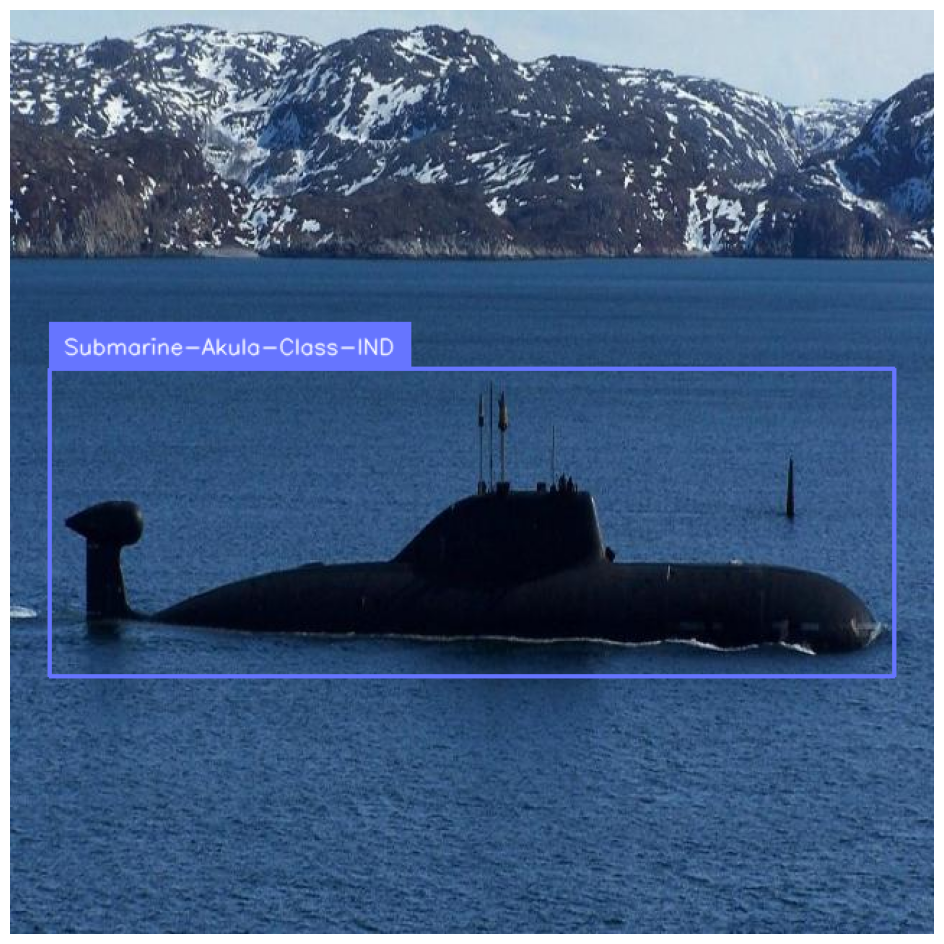

In [38]:
import random
import supervision as sv
import cv2

# Assuming ds is your dataset and model is your trained model
i = random.randint(0, len(ds) - 1)  # Ensure the index is within the valid range
image_path, image, target = ds[i]

# Get model predictions
results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# Create a copy of the image to annotate
annotated_image = image.copy()

# Extract bounding boxes and class IDs from detections
boxes = detections.xyxy  # Bounding boxes in [x_min, y_min, x_max, y_max] format
class_ids = detections.class_id  # Class IDs for each detection

# Get class names from the model
class_names = model.names  # Assuming model.names contains the class names

# Create annotators
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Draw bounding boxes
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)

# Add labels to the bounding boxes
labels = [f"{class_names[class_id]}" for class_id in class_ids]
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# Plot the image with bounding boxes and labels
sv.plot_image(annotated_image)

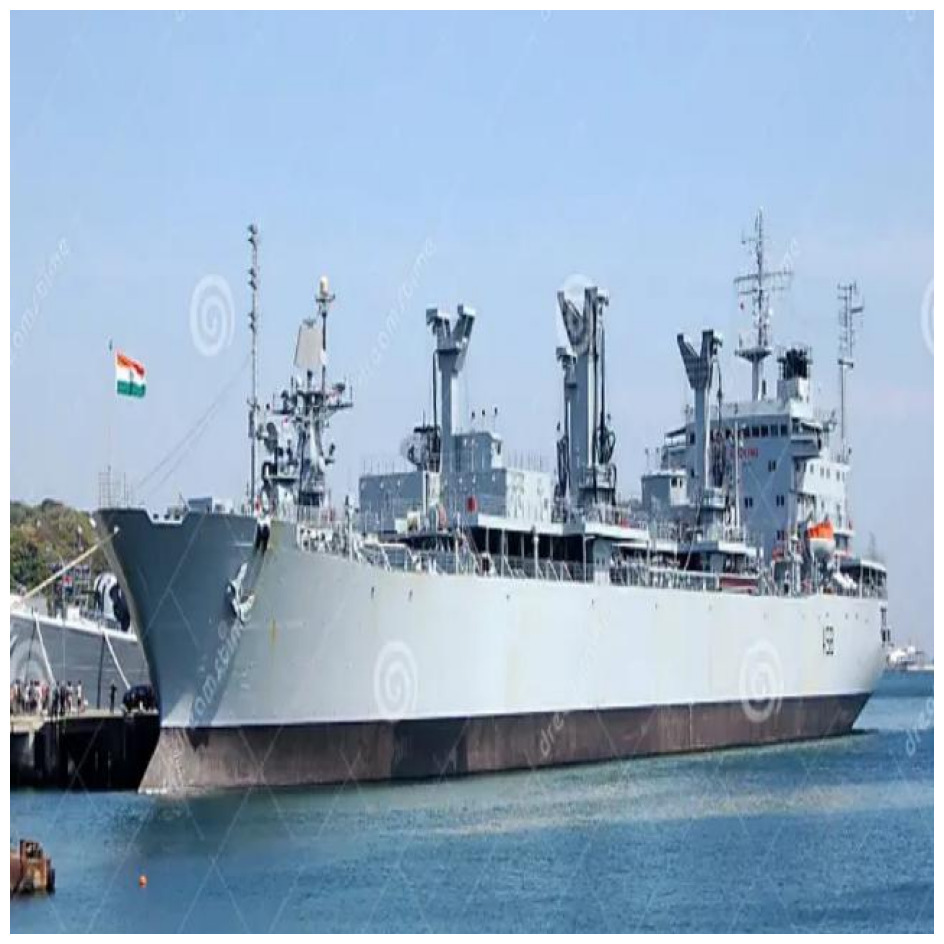

In [53]:
import random
import supervision as sv
import cv2

# Assuming ds is your dataset and model is your trained model
i = random.randint(0, len(ds) - 1)  # Ensure the index is within the valid range
image_path, image, target = ds[i]

# Get model predictions
results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

# Create a copy of the image to annotate
annotated_image = image.copy()

# Extract bounding boxes and class IDs from detections
boxes = detections.xyxy  # Bounding boxes in [x_min, y_min, x_max, y_max] format
class_ids = detections.class_id  # Class IDs for each detection

# Get class names from the model
class_names = model.names  # Assuming model.names contains the class names

# Create annotators
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Draw bounding boxes
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)

# Add labels to the bounding boxes
labels = [f"{class_names[class_id]}" for class_id in class_ids]
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections, labels=labels)

# Plot the image with bounding boxes and labels
sv.plot_image(annotated_image)